In [1]:
import numpy as np
import openmc
import math
import dagmc_h5m_file_inspector as di
import openmc_fusion_benchmarks as ofb
import matplotlib.pyplot as plt

import helpers

di.get_volumes_and_materials_from_h5m("../dagmc_file/geometry_a_volmesh.h5m")

{2: 'void', 11: '2', 32: '2', 22: '1'}

In [2]:
# DATA CONFIGURATIONS
# cross_sections_path = r'/home/davide/openmc_models/CROSS_SECTIONS/endfb-viii.0-hdf5/cross_sections.xml'
cross_sections_path = r'/home/davide/openmc_models/CROSS_SECTIONS/lanl_data_libraries/lib80x_hdf5/cross_sections.xml'
openmc.config['cross_sections'] = cross_sections_path

In [3]:
# Instantiate Model object
model = openmc.Model()

############################################################################
# Define Materials

# 
mat_1 = openmc.Material(material_id=1)
mat_1.set_density('g/cm3', 1.223)
mat_1.add_nuclide('Al27', 0.9975488, 'ao')
mat_1.add_nuclide('Si28', 0.001329808, 'ao')
mat_1.add_nuclide('Si29', 6.752131e-05, 'ao')
mat_1.add_nuclide('Si30', 4.450956e-05, 'ao')
mat_1.add_nuclide('Fe54', 5.651123e-05, 'ao')
mat_1.add_nuclide('Fe56', 0.0008871055, 'ao')
mat_1.add_nuclide('Fe57', 2.048713e-05, 'ao')
mat_1.add_nuclide('Fe58', 2.726461e-06, 'ao')
mat_1.add_nuclide('Cu63', 2.938581e-05, 'ao')
mat_1.add_nuclide('Cu65', 1.309765e-05, 'ao')
# 
mat_2 = openmc.Material(material_id=2)
mat_2.set_density('g/cm3', 7.824)
mat_2.add_nuclide('Cr50', 0.00803825, 'wo')
mat_2.add_nuclide('Cr52', 0.15501, 'wo')
mat_2.add_nuclide('Cr53', 0.0175768, 'wo')
mat_2.add_nuclide('Cr54', 0.00437525, 'wo')
mat_2.add_nuclide('Fe54', 0.0411488, 'wo')
mat_2.add_nuclide('Fe56', 0.645948, 'wo')
mat_2.add_nuclide('Fe57', 0.0149178, 'wo')
mat_2.add_nuclide('Fe58', 0.00198528, 'wo')
mat_2.add_nuclide('Ni58', 0.0755655, 'wo')
mat_2.add_nuclide('Ni60', 0.0291075, 'wo')
mat_2.add_nuclide('Ni61', 0.0012654, 'wo')
mat_2.add_nuclide('Ni62', 0.00403374, 'wo')
mat_2.add_nuclide('Ni64', 0.00102786, 'wo')
#
mat_3 = openmc.Material(material_id=3, name='void') #hydrogen to simulate vacuum
mat_3.set_density('g/cm3', 0.000000000001)
mat_3.add_element('H', 1.0)

# create materials instance
model.materials = openmc.Materials([mat_1, mat_2, mat_3])

In [4]:
# DEFINING GEOMETRY
# makes use of the dagmc geometry
dag_univ = openmc.DAGMCUniverse("../../dagmc_file/geometry_a_volmesh.h5m")

# creates an edge of universe boundary surface
vac_surf = openmc.Sphere(r=100, surface_id=9999, boundary_type="vacuum") #surface 7 of CSG model

# specifies the region as below the universe boundary and inside the reflective surfaces
region = -vac_surf 

# creates a cell from the region and fills the cell with the dagmc geometry
containing_cell = openmc.Cell(cell_id=9999, region=region, fill=dag_univ)

model.geometry = openmc.Geometry(root=[containing_cell])

In [5]:
############################################################################
# Define Settings

# source definition
# oktavian source
# Create a point source
energies = np.array([
    0.10000, 0.13644, 0.15079, 0.16665, 0.18418, 0.20355, 0.22496, 0.24862, 
    0.27476, 0.30366, 0.33560, 0.37089, 0.40990, 0.45301, 0.50065, 0.55331, 
    0.61150, 0.67581, 0.74689, 0.82544, 0.91225, 1.00820, 1.11420, 1.23140, 
    1.36090, 1.50400, 1.66220, 1.83700, 2.03020, 2.24380, 2.47970, 2.74050, 
    3.02880, 3.34730, 3.69930, 4.08840, 4.51840, 4.99360, 5.51880, 6.09920, 
    6.74060, 7.44960, 8.23300, 9.09890, 10.05600, 11.11300, 12.28200, 13.57400, 
    15.00200, 16.57900, 18.32300, 20.25000
])*1e6

weights = np.array([
    3.00903e-05, 9.65131e-05, 2.80822e-05, 0.000306354, 0.000210096, 
    0.000205622, 0.000381712, 0.000300617, 0.000375540, 0.000512358, 
    0.000520925, 0.000630849, 0.000570806, 0.000734549, 0.000957807, 
    0.000969666, 0.001149970, 0.001293080, 0.001529980, 0.001626960, 
    0.001824140, 0.001787470, 0.001978300, 0.001942890, 0.001943650, 
    0.002018280, 0.002028830, 0.002114010, 0.002087760, 0.002137290, 
    0.002799080, 0.003490910, 0.001768780, 0.001823810, 0.001780180, 
    0.001644070, 0.001542990, 0.001405050, 0.001305960, 0.001378880, 
    0.001254140, 0.001359870, 0.001496050, 0.001911300, 0.002545630, 
    0.004641890, 0.020724400, 0.621470000, 0.295462000, 0.000602722, 
    1.92596e-05, 0.0
])

source = openmc.IndependentSource()
source.space = openmc.stats.Point((0, 0, 0))
source.angle = openmc.stats.Isotropic()
source.particle = 'neutron' 
source.energy = openmc.stats.Tabular(energies, weights, interpolation='histogram')

# Indicate how many particles to run
settings = openmc.Settings(run_mode='fixed source')
settings.photon_transport = False # True or False
settings.source = source
settings.batches = 100
settings.particles = int(1e4)
settings.output = {'tallies': False}

model.settings = settings

############################################################################
# Specify Tallies
# setup the filters for the cell tally
# vessel_surface_filter = openmc.SurfaceFilter(surf_6)
vessel_surface_filter = openmc.SurfaceFilter(182) # outer radius of outer steel vessel
neutron_particle_filter = openmc.ParticleFilter(['neutron'])
photon_particle_filter = openmc.ParticleFilter(['photon'])

neutron_energies = np.array([
    0.97122E-01, 1.01090E-01, 1.05210E-01, 1.09500E-01, 1.13970E-01, 1.18620E-01,  
    1.23470E-01, 1.28500E-01, 1.33750E-01, 1.39210E-01, 1.44890E-01, 1.50800E-01,
    1.56960E-01, 1.63360E-01, 1.70030E-01, 1.76970E-01, 1.84190E-01, 1.91710E-01,
    1.99530E-01, 2.07670E-01, 2.16150E-01, 2.24970E-01, 2.34150E-01, 2.43710E-01,
    2.53650E-01, 2.64000E-01, 2.74780E-01, 2.85990E-01, 2.97660E-01, 3.09810E-01,
    3.22450E-01, 3.35610E-01, 3.49310E-01, 3.63570E-01, 3.78400E-01, 3.93850E-01,
    4.09920E-01, 4.26650E-01, 4.44060E-01, 4.62180E-01, 4.81050E-01, 5.00680E-01,
    5.21110E-01, 5.42380E-01, 5.64510E-01, 5.87550E-01, 6.11530E-01, 6.36480E-01,
    6.62460E-01, 6.89500E-01, 7.17630E-01, 7.46920E-01, 7.77400E-01, 8.09130E-01,
    8.42150E-01, 8.76520E-01, 9.12290E-01, 9.49520E-01, 9.88270E-01, 1.02860E+00,
    1.07060E+00, 1.11430E+00, 1.15980E+00, 1.20710E+00, 1.25630E+00, 1.30760E+00,
    1.36100E+00, 1.41650E+00, 1.47430E+00, 1.53450E+00, 1.59710E+00, 1.66230E+00,
    1.73010E+00, 1.80080E+00, 1.87420E+00, 1.95070E+00, 2.03030E+00, 2.11320E+00,
    2.19940E+00, 2.28920E+00, 2.38260E+00, 2.47990E+00, 2.58110E+00, 2.68640E+00,
    2.79600E+00, 2.91010E+00, 3.02890E+00, 3.15250E+00, 3.28120E+00, 3.41510E+00,
    3.55450E+00, 3.69950E+00, 3.85050E+00, 4.00760E+00, 4.17120E+00, 4.34140E+00,
    4.51860E+00, 4.70300E+00, 4.89490E+00, 5.09470E+00, 5.30260E+00, 5.51900E+00,
    5.74430E+00, 5.97870E+00, 6.22270E+00, 6.47660E+00, 6.74100E+00, 7.01610E+00,
    7.30240E+00, 7.60040E+00, 7.91060E+00, 8.23340E+00, 8.56940E+00, 8.91920E+00,
    9.28320E+00, 9.66200E+00, 1.00560E+01, 1.04670E+01, 1.08940E+01, 1.13390E+01,
    1.18010E+01, 1.22830E+01, 1.27840E+01, 1.33060E+01, 1.38490E+01, 1.44140E+01,
    1.50020E+01, 1.56150E+01, 1.62520E+01, 1.69150E+01, 1.76050E+01, 1.83240E+01,
    1.90720E+01, 1.98500E+01, 2.06600E+01  
])*1e6

photon_energies = np.array([
    5.00000E-01, 6.00000E-01, 7.00000E-01, 8.00000E-01, 9.00000E-01, 1.00000E+00,
    1.10000E+00, 1.20000E+00, 1.30000E+00, 1.40000E+00, 1.50000E+00, 1.60000E+00,
    1.70000E+00, 1.80000E+00, 1.90000E+00, 2.00000E+00, 2.10000E+00, 2.20000E+00,
    2.30000E+00, 2.40000E+00, 2.50000E+00, 2.60000E+00, 2.70000E+00, 2.80000E+00,
    2.90000E+00, 3.00000E+00, 3.10000E+00, 3.20000E+00, 3.30000E+00, 3.40000E+00,
    3.50000E+00, 3.60000E+00, 3.70000E+00, 3.80000E+00, 3.90000E+00, 4.00000E+00,
    4.10000E+00, 4.20000E+00, 4.30000E+00, 4.40000E+00, 4.50000E+00, 4.60000E+00,
    4.70000E+00, 4.80000E+00, 4.90000E+00, 5.00000E+00, 5.50000E+00, 6.00000E+00,
    6.50000E+00, 7.00000E+00, 7.50000E+00, 8.00000E+00, 8.50000E+00, 9.00000E+00,
    9.50000E+00, 1.00000E+01, 1.05000E+01, 1.10000E+01
])*1e6

energy_neutron_filter = openmc.EnergyFilter(neutron_energies)
energy_photon_filter = openmc.EnergyFilter(photon_energies)

#creates an empty tally object
model.tallies = openmc.Tallies()

# create the tally
neutron_surface_spectra_tally = openmc.Tally(name='nspectrum')
neutron_surface_spectra_tally.scores = ['current']
neutron_surface_spectra_tally.filters = [vessel_surface_filter, neutron_particle_filter, energy_neutron_filter]
model.tallies.append(neutron_surface_spectra_tally)

photon_surface_spectra_tally = openmc.Tally(name='gspectrum')
photon_surface_spectra_tally.scores = ['current']
photon_surface_spectra_tally.filters = [vessel_surface_filter, photon_particle_filter, energy_photon_filter]
model.tallies.append(photon_surface_spectra_tally)

# define the folder names for storing the statepoints
cwd = 'results'
model.settings = settings

In [49]:
model.run(cwd=cwd)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/davide/MIT/Repositories/openmc_fusion_benchmarks/models/oktavian/dagmc_oktavian_al/results/statepoint.100.h5')

In [6]:
# read conderc data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')

In [51]:
# # read statepoint file
# openmc_file = ofb.ResultsFromOpenmc('statepoint.100.h5')

# xaxis_name = 'energy low [eV]'
# openmc_file.tally_to_hdf(tally_name=f'nspectrum',
#                             normalize_over=helpers.surface,
#                             xs_library='DAGMC-ENDFB-8.0',
#                             xaxis_name=xaxis_name,
#                             path_to_database='results_database',
#                             when='October 2024',
#                             where='MIT-PSFC')

# openmc_file.tally_to_hdf(tally_name=f'gspectrum',
#                             normalize_over=helpers.surface,
#                             xs_library='DAGMC-ENDFB-8.0',
#                             xaxis_name=xaxis_name,
#                             path_to_database='results_database',
#                             when='October 2024',
#                             where='MIT-PSFC')

In [7]:
# read statepoint file
openmc_file = ofb.ResultsFromOpenmc('statepoint.100.h5')

xaxis_name = 'energy low [eV]'
openmc_file.tally_to_hdf(tally_name=f'nspectrum',
                            normalize_over=helpers.surface,
                            xs_library='DAGMC-LANL-ENDFB-8.0.2',
                            xaxis_name=xaxis_name,
                            path_to_database='results_database',
                            when='October 2024',
                            where='MIT-PSFC')

openmc_file.tally_to_hdf(tally_name=f'gspectrum',
                            normalize_over=helpers.surface,
                            xs_library='DAGMC-LANL-ENDFB-8.0.2',
                            xaxis_name=xaxis_name,
                            path_to_database='results_database',
                            when='October 2024',
                            where='MIT-PSFC')

/home/davide/anaconda3/envs/openmc0.14/lib/python3.12/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'energy low [eV]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/davide/anaconda3/envs/openmc0.14/lib/python3.12/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'energy high [eV]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/davide/anaconda3/envs/openmc0.14/lib/python3.12/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'std. dev.'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use 

In [8]:
# read openmc results in results_database/
openmc_csg_endfb80_file = ofb.ResultsFromDatabase('openmc-0-14-0_endfb80.h5', path='results_database')
openmc_dagmc_endfb80_file = ofb.ResultsFromDatabase('openmc-0-14-0_dagmcendfb80.h5', path='results_database')
openmc_dagmc_lanl_endfb80_file = ofb.ResultsFromDatabase('openmc-0-14-0_dagmclanlendfb80.h5', path='results_database')
openmc_dagmc_lanl_endfb80_file2 = ofb.ResultsFromDatabase('openmc-0-14-0_dagmclanlendfb802.h5', path='results_database')

In [9]:
# read mcnp results in results_database/
mcnp_endfb80_file = ofb.ResultsFromDatabase('mcnp-6-1-1b_endfb80.h5', path='results_database')

In [10]:
# experiment from results_database/
n21 = experiment_file.get_tally_dataframe('nspectrum')
g41 = experiment_file.get_tally_dataframe('gspectrum')

# openmc from results_database/
openmc_csg_endfb80_n21 = openmc_csg_endfb80_file.get_tally_dataframe('nspectrum')
openmc_csg_endfb80_g41 = openmc_csg_endfb80_file.get_tally_dataframe('gspectrum')

openmc_dagmc_endfb80_n21 = openmc_dagmc_endfb80_file.get_tally_dataframe('nspectrum')
openmc_dagmc_endfb80_g41 = openmc_dagmc_endfb80_file.get_tally_dataframe('gspectrum')

openmc_dagmc_lanl_endfb80_n21 = openmc_dagmc_lanl_endfb80_file.get_tally_dataframe('nspectrum')
openmc_dagmc_lanl_endfb80_g41 = openmc_dagmc_lanl_endfb80_file.get_tally_dataframe('gspectrum')

openmc_dagmc_lanl_endfb802_n21 = openmc_dagmc_lanl_endfb80_file2.get_tally_dataframe('nspectrum')
openmc_dagmc_lanl_endfb802_g41 = openmc_dagmc_lanl_endfb80_file2.get_tally_dataframe('gspectrum')

# mcnp from results_database/
mcnp_endfb80_n21 = mcnp_endfb80_file.get_tally_dataframe('nspectrum')
mcnp_endfb80_g41 = mcnp_endfb80_file.get_tally_dataframe('gspectrum')

In [11]:
ylabel_n = r'Neutron flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'
tally_name = 'nspectrum'
xaxis = experiment_file.get_tally_xaxis(tally_name)

In [12]:
# preprocessing
n21 = ofb.rescale_to_lethargy(n21)
openmc_csg_endfb80_n21 = ofb.rescale_to_lethargy(openmc_csg_endfb80_n21)
openmc_dagmc_endfb80_n21 = ofb.rescale_to_lethargy(openmc_dagmc_endfb80_n21)
openmc_dagmc_lanl_endfb80_n21 = ofb.rescale_to_lethargy(openmc_dagmc_lanl_endfb80_n21)
openmc_dagmc_lanl_endfb802_n21 = ofb.rescale_to_lethargy(openmc_dagmc_lanl_endfb802_n21)

mcnp_endfb80_n21 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(mcnp_endfb80_n21, n21['energy low [eV]'], n21['energy high [eV]']))

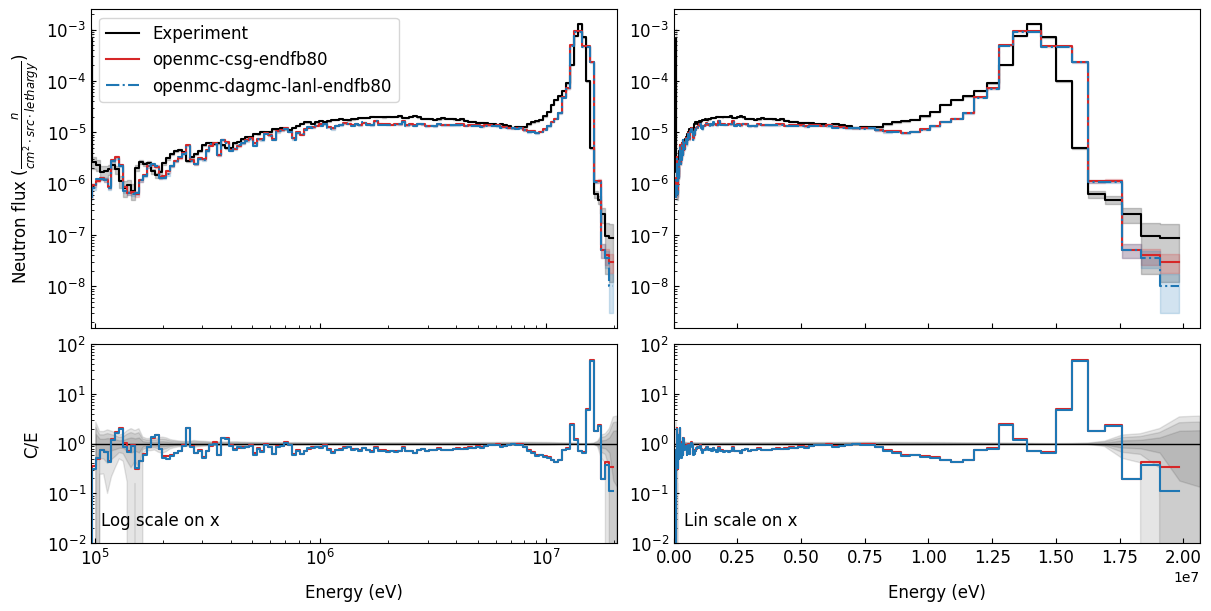

In [13]:
# generate figure
plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel_n)
plot.add_reference_results(reference_data=n21, label='Experiment')
plot.add_computed_results(computed_data=openmc_csg_endfb80_n21, color='tab:red', alpha=1, label='openmc-csg-endfb80')
# plot.add_computed_results(computed_data=openmc_dagmc_endfb80_n21, color='tab:green', ls='--', alpha=1, label='openmc-dagmc-endfb80')
plot.add_computed_results(computed_data=openmc_dagmc_lanl_endfb80_n21, color='tab:blue', ls='-.', alpha=1, label='openmc-dagmc-lanl-endfb80')
# plot.add_computed_results(computed_data=openmc_dagmc_lanl_endfb802_n21, color='tab:blue', ls='-.', alpha=1, label='2-openmc-dagmc-lanl-endfb80')

# plot.add_computed_results(computed_data=mcnp_endfb80_n21, color='tab:pink', alpha=1, label='mcnp-endfb80')

In [59]:
ylabel_g = r'Gamma flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'
tally_name = 'gspectrum'
xaxis = experiment_file.get_tally_xaxis(tally_name)

In [60]:
# preprocessing
g41 = ofb.rescale_to_lethargy(g41)
openmc_csg_endfb80_g41 = ofb.rescale_to_lethargy(openmc_csg_endfb80_g41)
openmc_dagmc_endfb80_g41 = ofb.rescale_to_lethargy(openmc_dagmc_endfb80_g41)
mcnp_endfb80_g41 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(mcnp_endfb80_g41, g41['energy low [eV]'], g41['energy high [eV]']))

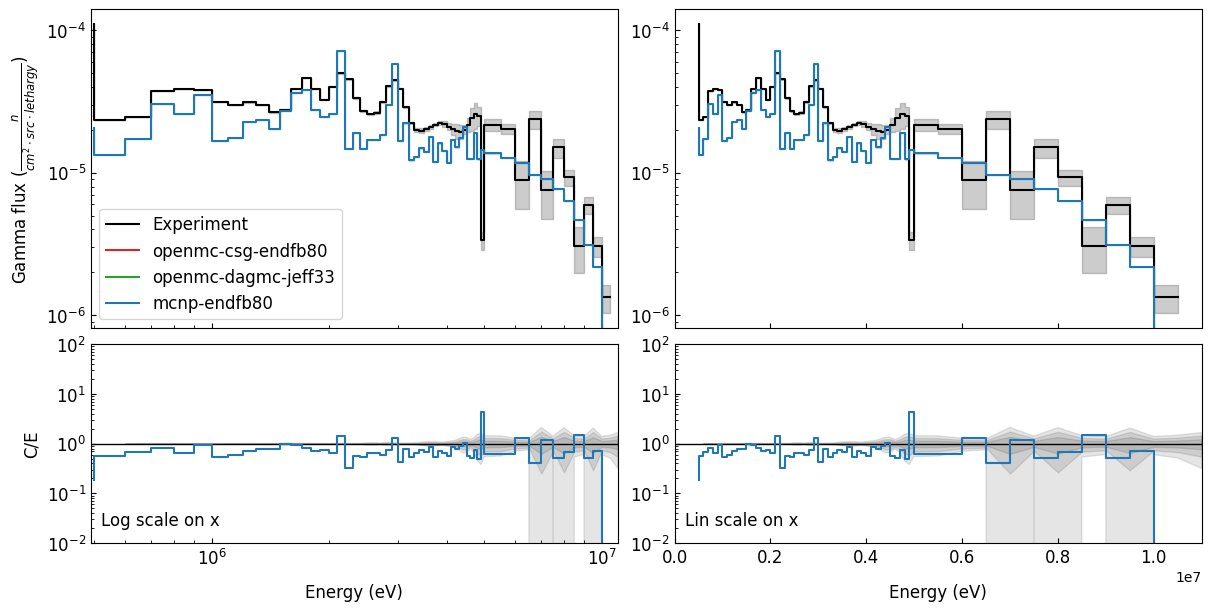

In [61]:
# generate figure
plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel_g)
plot.add_reference_results(reference_data=g41, label='Experiment')
plot.add_computed_results(computed_data=openmc_csg_endfb80_g41, color='tab:red', alpha=1, label='openmc-csg-endfb80')
plot.add_computed_results(computed_data=openmc_dagmc_endfb80_g41, color='tab:green', alpha=1, label='openmc-dagmc-jeff33')
plot.add_computed_results(computed_data=mcnp_endfb80_g41, color='tab:blue', alpha=1, label='mcnp-endfb80')